<a href="https://colab.research.google.com/github/gabrielfreire08/ATSIA/blob/main/atsia_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabla de contenidos

- [1 - Librerías](#lib)
- [2 - Paths para Proyecto](#path)
- [3 - Análisis de Datos Exploratorios (EDA)](#eda)
- [4 - Data Augmentation](#aug)
- [5 - Metadata](#meta)
- [6 - Carga de imágenes y metadata](#carga)
- [7 - Creación de DataBlock](#db)
- [8 - Función de Accuracy: ATSIA_ACC](#acc_atsia)
- [9 - Función de Pérdida: Binary Cross-Entropy with Logits Loss](#loss_fun)
- [10 - Modelo](#model)
- [11 - Métricas](#metrics)
- [12 - Resutados](#results)
- [13 - Widget Prueba](#widget)

<a name='lib'></a>
## Librerías

In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *

import os
import seaborn as sns
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

<a name='path'></a>
## Paths para proyecto

In [2]:
main_path = Path(os.getcwd())
Path.BASE_PATH = main_path

In [3]:
path = Path(main_path, "img_split")

## Obtención de imágenes del dataset

In [4]:
fns = get_image_files(path)
fns

(#2065) [Path('img_split/valid/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (119).png'),Path('img_split/valid/Branquias/1 (75).png'),Path('img_split/valid/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (5).png'),Path('img_split/valid/Branquias/S_G1_M_G0_N_G0_P_G2_AF_G1.png'),Path('img_split/valid/Branquias/S_G3-M_G0-N_G1-P_G0-AF_G0.png'),Path('img_split/valid/Branquias/S_G2-M_G2-N_G1-P_G0-AF_G0.png'),Path('img_split/valid/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (44).png'),Path('img_split/valid/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (6).png'),Path('img_split/valid/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G1.png'),Path('img_split/valid/Branquias/S_G2-M_G0-N_G0-P_G0-AF_G0(1).png')...]

In [5]:
failed = verify_images(fns)
failed

(#0) []

In [6]:
failed.map(Path.unlink);

<a name='db'></a> 
## Creación de DataBlock

In [7]:
def get_data(presize, resize, test = False):
    #Get the data in the form of :
    #Train --> 0.75
    #Val   --> 0.15
    #Test  -->0.10
    
    if test == False:
        return DataBlock(blocks=(ImageBlock, CategoryBlock),
                         get_items = get_image_files,
                         item_tfms = Resize(presize, method='crop', pad_mode='zeros'), # RatioResize(500)
                         splitter = GrandparentSplitter(),
                         get_y = parent_label,
                         batch_tfms =[*aug_transforms(size = resize,
                                                      mult=1.0,
                                                      do_flip=True,
                                                      flip_vert=True,
                                                      max_rotate=10.0, 
                                                      min_zoom=1.0, 
                                                      max_zoom=1.2,   
                                                      mode='bilinear', 
                                                      pad_mode='zeros',  
                                                      min_scale=0.75),Normalize.from_stats(*imagenet_stats)]
                        )
    
    #For test we do not need to partion the data. Set RandomSplitter to 0.
    #Also, no data augmentation needs to be done.
    else:
        return DataBlock(blocks=(ImageBlock, CategoryBlock),
                         get_items = get_image_files,
                         item_tfms = Resize(presize, method='crop', pad_mode='zeros'),
                         splitter = TrainTestSplitter(test_size=0.93, random_state=42),
                         get_y = parent_label,
                        )

In [8]:
dblock = get_data(500, 250, test = False)

### Creación del Dataset

In [9]:
dsets = dblock.datasets(Path(path))
dsets.train[0]

(PILImage mode=RGB size=1024x766, TensorCategory(1))

In [10]:
dsets.train[0][1]

TensorCategory(1)

In [11]:
idxs = int(dsets.train[0][1])
dsets.train.vocab[idxs]

'Branquias'

### Creación del datablock

### División del dataloader en train/valid

In [12]:
dls = dblock.dataloaders(Path(path), bs=16)

/home/ubuntu/miniconda3/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


### División del dataloader en test

In [13]:
dblock_test = get_data(500, 250, test = True)

In [14]:
dls_test = dblock_test.dataloaders(Path(path, "test"), bs=16)

### Cantidad de categorías/clases

In [15]:
print(len(dls.vocab))
labels = dls.vocab
print(labels)

5
['AmpollaRectal', 'Branquias', 'Hepatopancreas', 'Intestinos', 'Uropodos']


### Cantidad de datos en cada uno de los grupos: train/valid/test

### Train

In [16]:
len(dls.train.items)

1547

In [17]:
dls.train.items

[Path('img_split/train/Branquias/1 (131).png'),
 Path('img_split/train/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (226).png'),
 Path('img_split/train/Branquias/1 (206).png'),
 Path('img_split/train/Branquias/1 (62).png'),
 Path('img_split/train/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (237).png'),
 Path('img_split/train/Branquias/1 (134).png'),
 Path('img_split/train/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (198).png'),
 Path('img_split/train/Branquias/S_G1_M_G0_N_G2_P_G1_AF_G0.png'),
 Path('img_split/train/Branquias/AVM_07-02-2022_17-26-59-S_G0-M_G0-N_G0-P_G0-AF_G0.png'),
 Path('img_split/train/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (42).png'),
 Path('img_split/train/Branquias/S_G2_M_G1_N_G1_P_G2_AF_G0.png'),
 Path('img_split/train/Branquias/S_G1_M_G0_N_G1_P_G1_AF_G0.png'),
 Path('img_split/train/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (160).png'),
 Path('img_split/train/Branquias/1 (151).png'),
 Path('img_split/train/Branquias/S_G0_M_G1_N_G4_P_G0_AF_G0.png'),
 Path('img_split/train/Branquias/1 (90).png

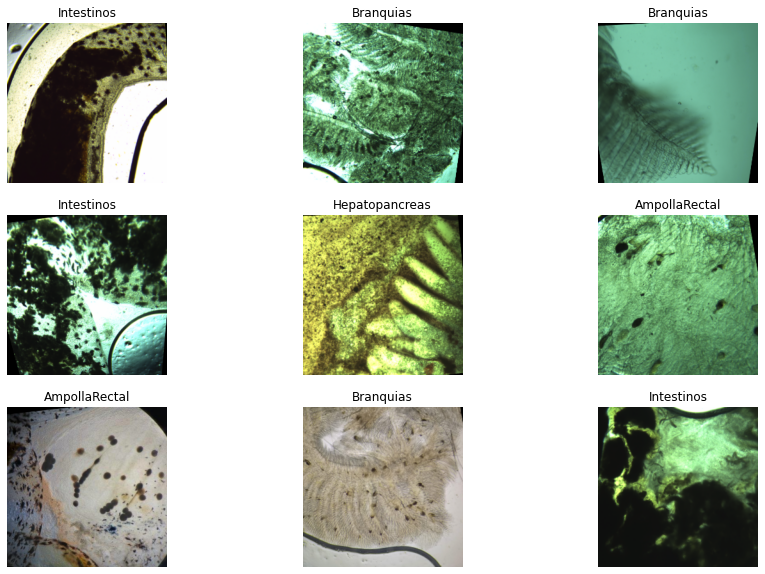

In [18]:
dls.train.show_batch(nrows=3, ncols=3, figsize=(15,10))

### Valid

In [19]:
len(dls.valid.items)

307

In [20]:
dls.valid.items

[Path('img_split/valid/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (119).png'),
 Path('img_split/valid/Branquias/1 (75).png'),
 Path('img_split/valid/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (5).png'),
 Path('img_split/valid/Branquias/S_G1_M_G0_N_G0_P_G2_AF_G1.png'),
 Path('img_split/valid/Branquias/S_G3-M_G0-N_G1-P_G0-AF_G0.png'),
 Path('img_split/valid/Branquias/S_G2-M_G2-N_G1-P_G0-AF_G0.png'),
 Path('img_split/valid/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (44).png'),
 Path('img_split/valid/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (6).png'),
 Path('img_split/valid/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G1.png'),
 Path('img_split/valid/Branquias/S_G2-M_G0-N_G0-P_G0-AF_G0(1).png'),
 Path('img_split/valid/Branquias/1 (96).png'),
 Path('img_split/valid/Branquias/S_G0_M_G0_N_G1_P_G0_AF_G0 (3).png'),
 Path('img_split/valid/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (86).png'),
 Path('img_split/valid/Branquias/1 (60).png'),
 Path('img_split/valid/Branquias/S_G4_M_G0_N_G0_P_G0_AF_G0 (6).png'),
 Path('img_split/valid/Bran

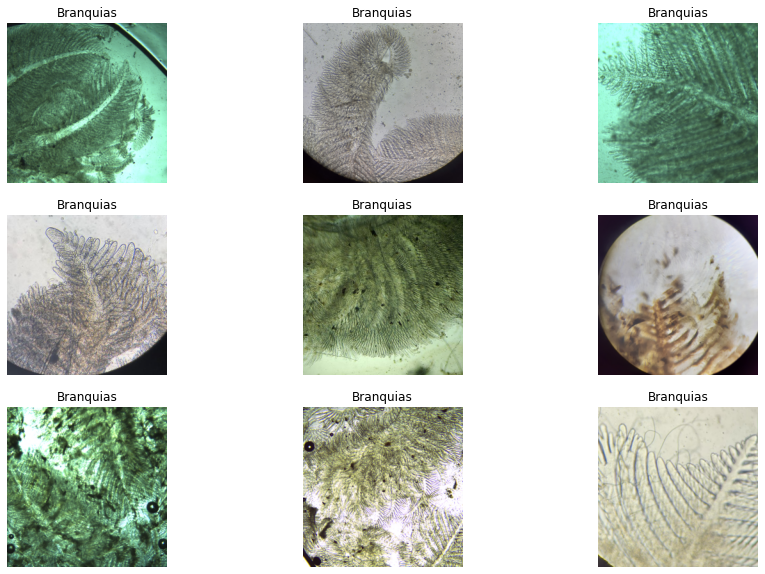

In [21]:
dls.valid.show_batch(nrows=3, ncols=3, figsize=(15,10))

### Test

In [22]:
len(dls_test.valid.items)

197

In [23]:
dls_test.valid.items

[Path('img_split/test/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (125).png'),
 Path('img_split/test/Intestinos/IS_795.png'),
 Path('img_split/test/Hepatopancreas/DT_G1-DC_G1-L_G0-M_G0-N_G0 (17).png'),
 Path('img_split/test/Uropodos/20200309_114743.png'),
 Path('img_split/test/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (36).png'),
 Path('img_split/test/AmpollaRectal/20180926_110427.png'),
 Path('img_split/test/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (171).png'),
 Path('img_split/test/Intestinos/IMG-20210525-WA0039.png'),
 Path('img_split/test/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (30).png'),
 Path('img_split/test/Hepatopancreas/DT_G2-DC_G1-L_G0-M_G2-N_G0 (2).png'),
 Path('img_split/test/Hepatopancreas/DT_G4-DC_G1-L_G3-M_G0-N_G0.png'),
 Path('img_split/test/AmpollaRectal/GG_G2_N_G0 (14).png'),
 Path('img_split/test/Intestinos/GT_G0_GG_G0_N_G1_A_G0_RC_G0_rew.png'),
 Path('img_split/test/Hepatopancreas/DT_G4-DC_G4-L_G4-M_G3-N_G4 (2).png'),
 Path('img_split/test/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (27).pn

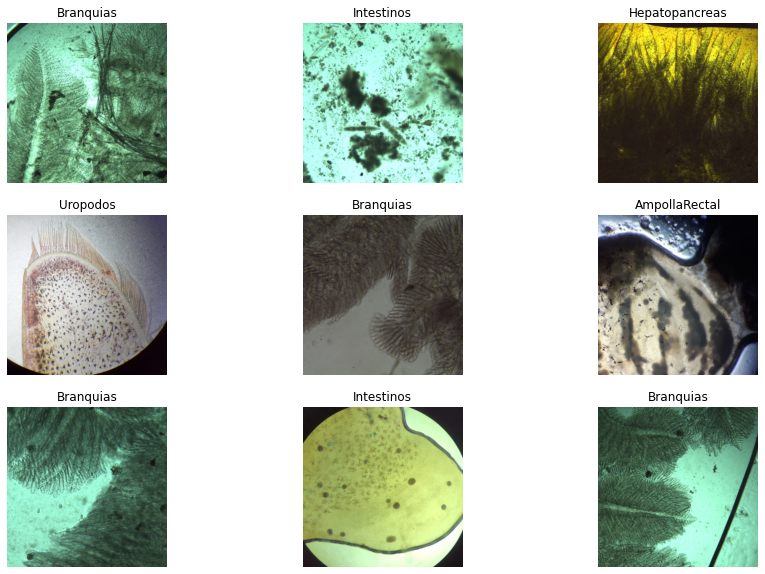

In [24]:
dls_test.valid.show_batch(nrows=3, ncols=3, figsize=(15,10))

<a name='model'></a> 
## Entrenamieto de Modelo

In [25]:
learn = cnn_learner(dls, 
                    resnet50, 
                    metrics = [accuracy, error_rate],
                    path = main_path
                    )

SuggestedLRs(valley=0.0014454397605732083)

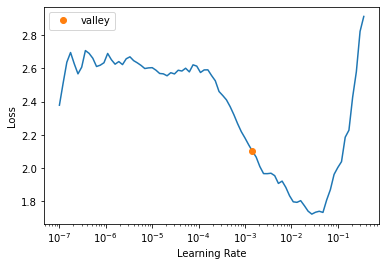

In [26]:
learn.lr_find()

In [27]:
cbs = [SaveModelCallback(monitor= 'accuracy', fname = "model_test"),
      MixUp()]
learn.fit_one_cycle(10, lr_max = slice(5e-4, 5e-2), cbs = cbs)

Better model found at epoch 0 with accuracy value: 0.8143322467803955.
Better model found at epoch 2 with accuracy value: 0.9283387660980225.
Better model found at epoch 6 with accuracy value: 0.9315961003303528.
Better model found at epoch 7 with accuracy value: 0.9348534345626831.
Better model found at epoch 8 with accuracy value: 0.9446253776550293.
Better model found at epoch 9 with accuracy value: 0.9511400461196899.


In [28]:
learn.unfreeze()

SuggestedLRs(valley=8.31763736641733e-06)

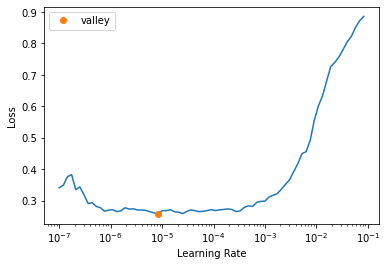

In [29]:
learn.lr_find()

In [30]:
cbs = [SaveModelCallback(monitor= 'accuracy', fname = "model_test"),
      MixUp()]
learn.fit_one_cycle(10, lr_max = slice(1e-5, 1e-4), cbs = cbs)

Better model found at epoch 0 with accuracy value: 0.9446253776550293.
Better model found at epoch 1 with accuracy value: 0.9511400461196899.
Better model found at epoch 6 with accuracy value: 0.9543973803520203.
Better model found at epoch 9 with accuracy value: 0.9609120488166809.


SuggestedLRs(valley=1.9054607491852948e-06)

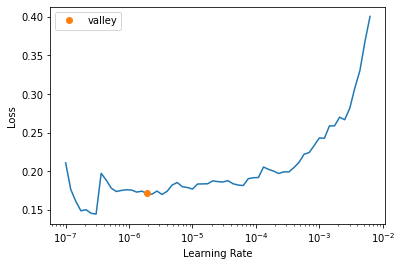

In [31]:
learn.lr_find()

In [32]:
cbs = [SaveModelCallback(monitor= 'accuracy', fname = 'model_test'),
      MixUp()]

learn.fine_tune(15, base_lr=3e-6, freeze_epochs = 5, cbs = cbs)

Better model found at epoch 0 with accuracy value: 0.9609120488166809.


Better model found at epoch 0 with accuracy value: 0.9478827118873596.
Better model found at epoch 2 with accuracy value: 0.9609120488166809.
Better model found at epoch 9 with accuracy value: 0.9641693830490112.


## Realizamos Presizing

In [33]:
dblock = get_data(750, 500, test = False)
dls = dblock.dataloaders(Path(path), bs=16)

learn = cnn_learner(dls, 
                    resnet50, 
                    metrics = [accuracy, error_rate],
                    path = main_path
                    )

SuggestedLRs(valley=0.0006918309954926372)

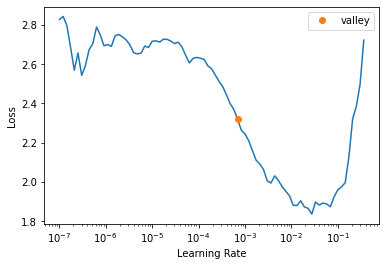

In [34]:
learn.lr_find()

In [35]:
# cbs = [SaveModelCallback(monitor= 'accuracy', fname = 'model_test'),
#       MixUp()]

# learn.fine_tune(30, base_lr=3e-3, freeze_epochs = 10, cbs = cbs)

In [36]:
cbs = [SaveModelCallback(monitor= 'accuracy', fname = "model_test"),
      MixUp()]
learn.fit_one_cycle(10, lr_max = slice(5e-4, 5e-2), cbs = cbs)

Better model found at epoch 0 with accuracy value: 0.7524430155754089.
Better model found at epoch 1 with accuracy value: 0.7622149586677551.
Better model found at epoch 2 with accuracy value: 0.9087947607040405.
Better model found at epoch 6 with accuracy value: 0.9218240976333618.
Better model found at epoch 7 with accuracy value: 0.9543973803520203.
Better model found at epoch 8 with accuracy value: 0.9576547145843506.


In [37]:
learn.unfreeze()

SuggestedLRs(valley=3.311311274956097e-06)

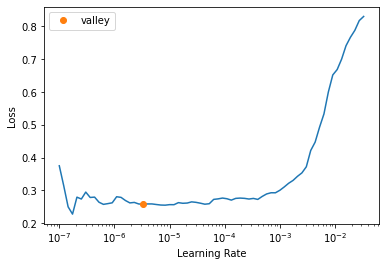

In [38]:
learn.lr_find()

In [39]:
cbs = [SaveModelCallback(monitor= 'accuracy', fname = "model_test"),
      MixUp()]
learn.fit_one_cycle(10, lr_max = slice(1e-5, 1e-4), cbs = cbs)

Better model found at epoch 0 with accuracy value: 0.9511400461196899.
Better model found at epoch 2 with accuracy value: 0.9576547145843506.
Better model found at epoch 3 with accuracy value: 0.9641693830490112.
Better model found at epoch 4 with accuracy value: 0.9674267172813416.


SuggestedLRs(valley=2.75422871709452e-06)

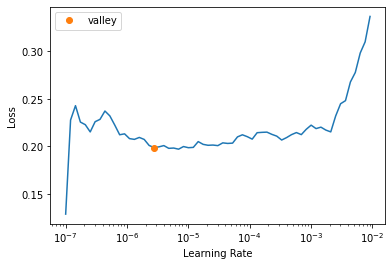

In [40]:
learn.lr_find()

In [41]:
cbs = [SaveModelCallback(monitor= 'accuracy', fname = 'model_test'),
      MixUp()]

learn.fine_tune(15, base_lr=3e-6, freeze_epochs = 5, cbs = cbs)

Better model found at epoch 0 with accuracy value: 0.9609120488166809.
Better model found at epoch 2 with accuracy value: 0.9674267172813416.


Better model found at epoch 0 with accuracy value: 0.9609120488166809.
Better model found at epoch 1 with accuracy value: 0.9674267172813416.


<a name='metrics'></a> 
## Métricas

In [42]:
## Ultimo presizing utilizado aplicado al test
dblock_test = get_data(750, 500, test = True)
dls_test = dblock_test.dataloaders(Path(path, "test"), bs = 16)

learn = cnn_learner(dls_test, 
                    resnet50, 
                    metrics = [accuracy, error_rate],
                    path = main_path
                    )

In [44]:
# learn.load("model_test_multiclass_09806")
learn.load("model_test")

In [45]:
len(dls_test.valid.items)

197

In [46]:
learn.metrics = accuracy
learn.validate(dl = dls_test.valid)

(#2) [0.24435773491859436,0.9441624283790588]

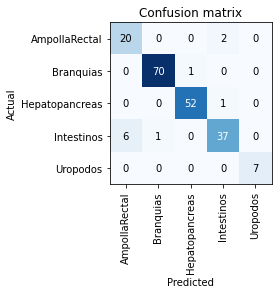

In [47]:
interp = ClassificationInterpretation.from_learner(learn, dl = dls_test.valid)
interp.plot_confusion_matrix()

In [48]:
interp.most_confused()

[('Intestinos', 'AmpollaRectal', 6),
 ('AmpollaRectal', 'Intestinos', 2),
 ('Branquias', 'Hepatopancreas', 1),
 ('Hepatopancreas', 'Intestinos', 1),
 ('Intestinos', 'Branquias', 1)]

In [49]:
interp.print_classification_report()

                precision    recall  f1-score   support

 AmpollaRectal       0.77      0.91      0.83        22
     Branquias       0.99      0.99      0.99        71
Hepatopancreas       0.98      0.98      0.98        53
    Intestinos       0.93      0.84      0.88        44
      Uropodos       1.00      1.00      1.00         7

      accuracy                           0.94       197
     macro avg       0.93      0.94      0.94       197
  weighted avg       0.95      0.94      0.94       197



In [50]:
interp.top_losses(10)

torch.return_types.topk(
values=TensorBase([3.7437, 3.2027, 2.7355, 2.3427, 2.1145, 1.9079, 1.2837, 1.2462, 1.1673,
        1.0322]),
indices=TensorBase([114, 177, 189,   7,  61,  67,  95, 122,  13, 158]))

In [55]:
x = 0
for i, loss in zip(interp.top_losses(10).indices, interp.top_losses(13).values):
    print(f"[{x}] {dls_test.valid_ds.items[i]} Loss: {int(loss)}")
    x += 1

[0] /home/ubuntu/ATSIA/img_split/test/Intestinos/IS_620.png Loss: 3
[1] /home/ubuntu/ATSIA/img_split/test/Intestinos/GG_G2.png Loss: 3
[2] /home/ubuntu/ATSIA/img_split/test/Intestinos/GREGARINA GAMETOCISTO_G2.png Loss: 2
[3] /home/ubuntu/ATSIA/img_split/test/Intestinos/IMG-20210525-WA0039.png Loss: 2
[4] /home/ubuntu/ATSIA/img_split/test/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (185).png Loss: 2
[5] /home/ubuntu/ATSIA/img_split/test/Intestinos/IS_759.png Loss: 1
[6] /home/ubuntu/ATSIA/img_split/test/Intestinos/2019-11-08 12.21.05.png Loss: 1
[7] /home/ubuntu/ATSIA/img_split/test/Intestinos/IS_730.png Loss: 1
[8] /home/ubuntu/ATSIA/img_split/test/Hepatopancreas/DT_G4-DC_G4-L_G4-M_G3-N_G4 (2).png Loss: 1
[9] /home/ubuntu/ATSIA/img_split/test/AmpollaRectal/GG_G1_N_G0 (16).png Loss: 1


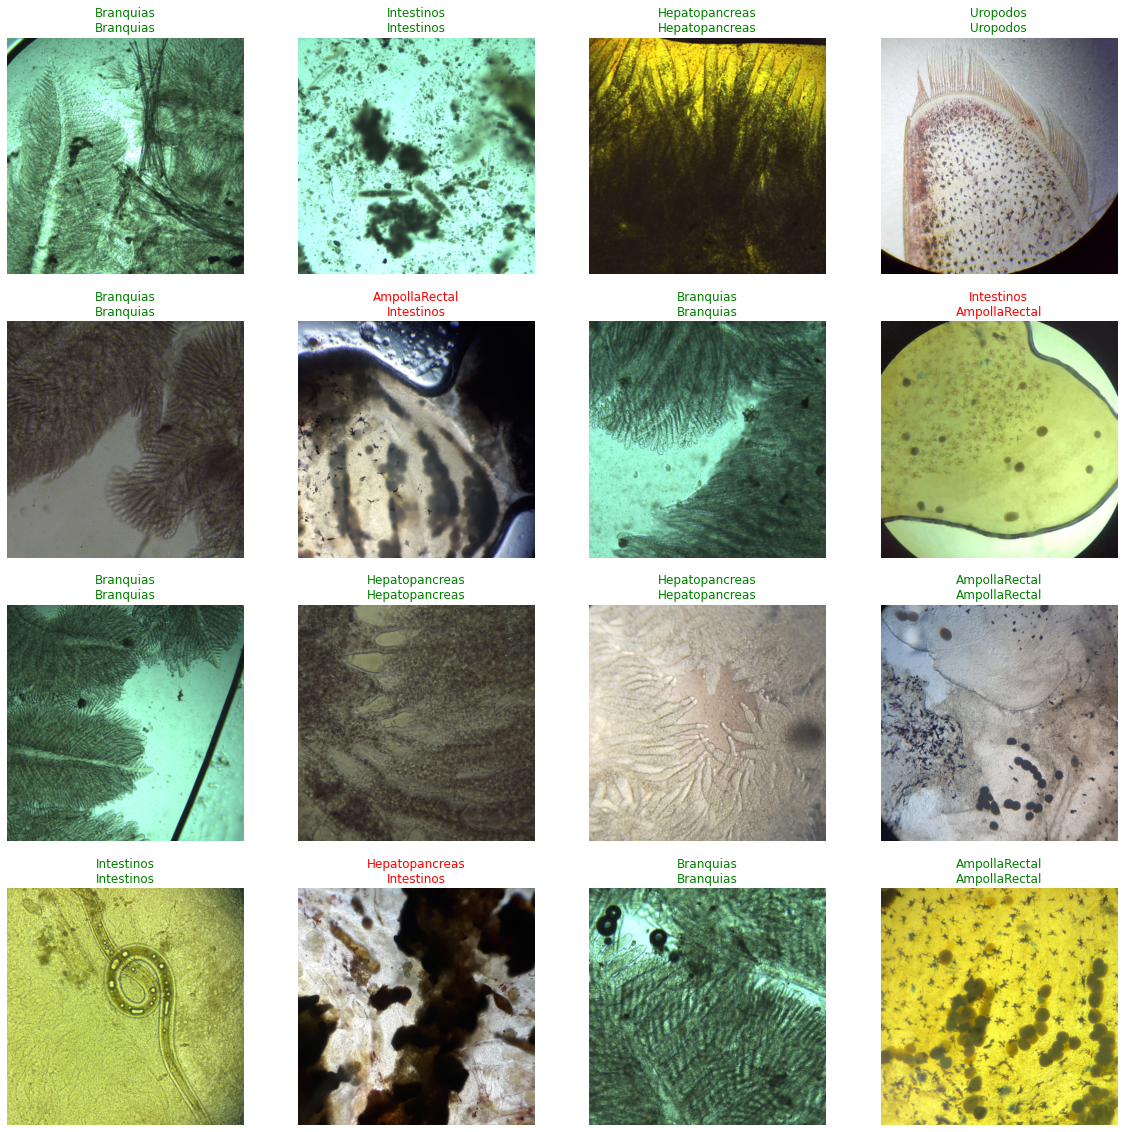

In [57]:
learn.show_results(dl = dls_test.valid, ds_idx = 0, max_n = 16, figsize = (20,20), shuffle=True)

<a name='results'></a> 
## Resultados

In [ ]:
dblock = get_data(750, 500)
dls = dblock.dataloaders(path, bs=16)

learn = cnn_learner(dls, 
                    resnet50, 
                    metrics = [accuracy, error_rate],
                    path = main_path
                    )

In [ ]:
learn.load("model_test_multiclass_09806")

In [ ]:
learn.metrics = accuracy
learn.validate()

In [ ]:
learn.export()

In [ ]:
learn.show_results(dl = dls.valid, ds_idx = 0, max_n = 16, figsize = (20,20), shuffle=True)

<a name='widget'></a> 
## Widget Test

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(500,500))
out_pl

In [ ]:
pred,pred_idx,probs = learn.predict(img)
pred